# 1DCNN code for damage detection

## Importing APIs

In [1]:
#imports
import os
import zipfile
%matplotlib inline
import random 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Conv1D, MaxPooling1D, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical,plot_model
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Callbacks

In [3]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_acc')>0.99) and (logs.get('acc')>0.99) and (logs.get('val_loss')<0.05) and (logs.get('loss')<0.05):
      print("\nReached perfect accuracy so cancelling training!")
      self.model.stop_training = True

epoch_schedule = myCallback()

In [4]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 5))

## Importing data

In [5]:
df_base = pd.read_csv('E:/PhD-MSR/OGWdataset/Guided_wave_basic_measurement_data/dataset/AllDatasets/combinedata/SHM_Baseline-1_filter.txt',header=None)
print(df_base.shape)

(22176, 13108)


In [6]:
df_dam = pd.read_csv('E:/PhD-MSR/OGWdataset/Guided_wave_basic_measurement_data/dataset/AllDatasets/combinedata/SHM_Damage_filter.txt',header=None)
print(df_dam.shape)

(22176, 13108)


In [7]:
df_base = np.array(df_base)
df_dam = np.array(df_dam)
df = np.concatenate([df_base,df_dam], axis=0)

In [8]:
# Function for RMSD (Root Mean Squared Difference)
def RMSD(base,dam):
    num = np.sum((base-dam)**2,axis=1)
    den = np.sum(base**2,axis=1)
    rmsd = np.sqrt(np.divide(num,den))
    return rmsd

In [9]:
# Call RMSD function
rmsd = RMSD(df_base,df_dam)

## Plotting dataset

In [10]:
seqlen = df.shape[1]
dT = 1e-7
time = np.arange(0,(seqlen)*dT,dT)
print(time.shape)

(13108,)


In [11]:
sigwindow = 1e-3
idx1 = 1000
idx2 = 13108

14727
0.03452000015664699


Text(0, 0.5, 'Norm Amplitude')

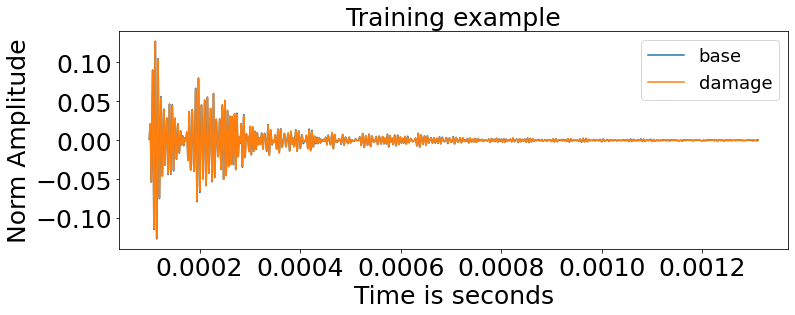

In [12]:
plt.figure(figsize=(12,4))
nn = random.randint(1,df_base.shape[0])
#nn=51
print(nn)
print(rmsd[nn])
plt.plot(time[idx1:idx2], df_base[nn,idx1: idx2])
plt.plot(time[idx1:idx2], df_dam[nn,idx1: idx2])
plt.title('Training example',fontsize=25)
plt.legend(['base', 'damage'], loc='upper right',fontsize=18)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time is seconds',fontsize=25)
plt.ylabel('Norm Amplitude',fontsize=25)

## Deciding Features and Labels

In [13]:
# Using only transmission channels
sch1 = np.arange(6,11+1,1)                   # sub channels with 1 as actuator and other as sensors
sch2 = np.arange(16,21+1,1)                  # sub channels with 2 as actuator and other as sensors
sch3 = np.arange(25,30+1,1)
sch4 = np.arange(33,38+1,1)
sch5 = np.arange(40,45+1,1)
sch6 = np.arange(46,51+1,1)
transch = np.concatenate([sch1,sch2,sch3,sch4,sch5,sch6], axis=0)
freqtransch = np.concatenate([transch,transch+66,transch+66*2], axis=0)

A = []
for i in range(1,28,1):                       # we are incorporating all damages, i = 1 here means D2
    damtransch = 792*i + freqtransch      
    A.append(damtransch)

A = np.concatenate(A)                         # concatenate all appended vectors
B = np.concatenate([freqtransch,A],axis=0)    # concatenate D1 with D2 to D28
print(B.shape)
print(B)

(3024,)
[    6     7     8 ... 21565 21566 21567]


In [14]:
#del df_base, df_dam

In [15]:
# Using only 'B' training samples
df_base = df_base[B, idx1:idx2]
df_dam = df_dam[B, idx1:idx2]

In [16]:
# Concatenate baseline and damage signals
df = np.concatenate([df_base,df_dam], axis=0)
X = np.array(df)
print(X.shape)

(6048, 12108)


In [17]:
# Input/Features and labels extraction
# Baseline = 0
# Damage = 1
mclass = df_base.shape[0]
y1 = np.zeros((mclass,1), dtype=int)
y2 = np.ones((mclass,1), dtype=int)

y = np.concatenate([y1,y2], axis=0)
y = np.array(y)
print(y.shape)

(6048, 1)


## Add Noise into the dataset

In [ ]:
#del Xn1,n1,r,maxX

In [18]:
# Random gaussian noise parameter
beta1 = 0.0025
beta2 = 0.003

mu = 0
sigma = 1

#random parameter with standard normal distribution
r = sigma*np.random.randn(X.shape[1],1) + mu   
r = np.transpose(r)
print(r.shape)

# Noisy signal
maxX = np.max(X)
maxX = np.array(maxX)
print(maxX)

n1 = beta1*r*maxX
n2 = beta2*r*maxX
print(n2.shape)

Xn1 = X + n1
Xn2 = X + n2
print(Xn2.shape)

# Signal to noise ratio
import math

rms_Xn = np.sqrt(np.mean(Xn2**2))
Power_Xn = rms_Xn**2
print(Power_Xn)

rms_n = np.sqrt(np.mean(n2**2))
Power_n = rms_n**2
print(Power_n)

SNR_dB = 10*math.log10(Power_Xn/Power_n)
print("SNR : ",SNR_dB)

(1, 12108)
0.664957667855495
(1, 12108)
(6048, 12108)
0.0012543115301581937
4.023462953566065e-06
SNR :  24.938054076337423


In [19]:
# Concatenate noisy and non-noisy samples
Xn = np.concatenate([X,Xn1,Xn2], axis=0)
yn = np.concatenate([y,y,y], axis=0)
print(Xn.shape)
print(yn.shape)

(18144, 12108)
(18144, 1)


4736


Text(0.5, 1.0, 'Training sample')

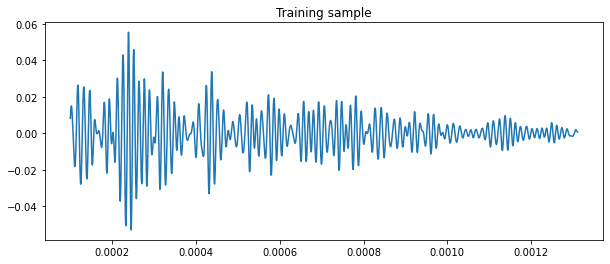

In [20]:
# Plot signals
D = random.randint(1, Xn.shape[0])
print(D)

plt.figure(figsize=(10,4))
plt.plot(time[idx1:idx2], Xn[D, 0 : Xn.shape[1]])
plt.title('Training sample')

## Splitting testing and test set

In [ ]:
# RERUN the model ==> Delete the model
del model

In [21]:
# split into train and test
# Run this line of code for every run of the code if some parameters are changed
X1, X_test, y1, y_test = train_test_split(Xn,yn, test_size = 0.005, random_state = 42)

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X1,y1, test_size = 0.1, random_state = 42)

In [23]:
# Shapes of training and test tests
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train = np.array(y_train)
y_train = np.array(y_train)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(16247, 12108)
(1806, 12108)
(91, 12108)
(16247, 1)
(1806, 1)
(91, 1)


## Reshape the arrays

In [24]:
# reshape the arrays
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_valid = np.reshape(X_valid, (X_valid.shape[0],X_valid.shape[1],1))
X_test  = np.reshape(X_test,  (X_test.shape[0],X_test.shape[1],1))

In [25]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
# print(y_train)

(16247, 12108, 1)
(1806, 12108, 1)
(16247, 1)
(1806, 1)


## Model Architecture

In [26]:
# define model architecture : 1DCNN-classification
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

Inp = Input(shape=(X.shape[1],1))

x1 = Sequential()

x1 = Conv1D(filters=16, kernel_size=3, input_shape=(X.shape[1],1))(Inp)
#x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(x1)
#x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=64, kernel_size=3, activation='relu')(x1)
#x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=128, kernel_size=3, activation='relu')(x1)
#x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=256, kernel_size=3, activation='relu')(x1)
#x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Flatten()(x1)

cnn1 = Model(Inp,x1)

In [27]:
from keras.layers import concatenate
#x = concatenate([cnn1.output,cnn2.output])
x = cnn1.output
#---------------------------------
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
#x = Dense(16, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
#---------------------------------
model = Model(inputs = Inp, outputs=x)

In [28]:
# summary of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12108, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12106, 16)         64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6053, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6051, 32)          1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3025, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3023, 64)          6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1511, 64)          0   

In [41]:
# save model.summary()
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [ ]:
import keras
keras.utils.plot_model(model, "detect1DCNN.png")

In [29]:
# Functions for recall, precision and f1 score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Choose Hyperparameters

In [30]:
# compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['acc', precision_m, recall_m])

## Training

In [31]:
# train the model
bsize = 128
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5000, batch_size = bsize, verbose=2, shuffle = True, callbacks = [epoch_schedule])

Train on 16247 samples, validate on 1806 samples
Epoch 1/5000
 - 13s - loss: 0.6932 - acc: 0.4944 - precision_m: 0.4373 - recall_m: 0.0891 - val_loss: 0.6932 - val_acc: 0.4884 - val_precision_m: 0.2333 - val_recall_m: 0.0052
Epoch 2/5000
 - 9s - loss: 0.6932 - acc: 0.4984 - precision_m: 0.3088 - recall_m: 0.0879 - val_loss: 0.6933 - val_acc: 0.4762 - val_precision_m: 0.3874 - val_recall_m: 0.0441
Epoch 3/5000
 - 9s - loss: 0.6932 - acc: 0.4973 - precision_m: 0.4861 - recall_m: 0.0677 - val_loss: 0.6933 - val_acc: 0.4729 - val_precision_m: 0.4355 - val_recall_m: 0.0897
Epoch 4/5000
 - 9s - loss: 0.6931 - acc: 0.4997 - precision_m: 0.5006 - recall_m: 0.1674 - val_loss: 0.6934 - val_acc: 0.4762 - val_precision_m: 0.4709 - val_recall_m: 0.1098
Epoch 5/5000
 - 9s - loss: 0.6932 - acc: 0.4986 - precision_m: 0.4696 - recall_m: 0.1806 - val_loss: 0.6934 - val_acc: 0.4779 - val_precision_m: 0.4481 - val_recall_m: 0.0704
Epoch 6/5000
 - 9s - loss: 0.6931 - acc: 0.5059 - precision_m: 0.5274 - rec

Epoch 48/5000
 - 10s - loss: 0.6896 - acc: 0.5401 - precision_m: 0.5584 - recall_m: 0.5244 - val_loss: 0.6943 - val_acc: 0.5100 - val_precision_m: 0.5196 - val_recall_m: 0.8421
Epoch 49/5000
 - 10s - loss: 0.6894 - acc: 0.5376 - precision_m: 0.5474 - recall_m: 0.5189 - val_loss: 0.6942 - val_acc: 0.5199 - val_precision_m: 0.5293 - val_recall_m: 0.8348
Epoch 50/5000
 - 10s - loss: 0.6893 - acc: 0.5434 - precision_m: 0.5505 - recall_m: 0.5319 - val_loss: 0.6944 - val_acc: 0.5022 - val_precision_m: 0.5252 - val_recall_m: 0.3845
Epoch 51/5000
 - 10s - loss: 0.6893 - acc: 0.5419 - precision_m: 0.5564 - recall_m: 0.5023 - val_loss: 0.6950 - val_acc: 0.5089 - val_precision_m: 0.5681 - val_recall_m: 0.2305
Epoch 52/5000
 - 10s - loss: 0.6886 - acc: 0.5460 - precision_m: 0.5609 - recall_m: 0.5064 - val_loss: 0.6936 - val_acc: 0.5133 - val_precision_m: 0.5306 - val_recall_m: 0.5832
Epoch 53/5000
 - 10s - loss: 0.6893 - acc: 0.5384 - precision_m: 0.5526 - recall_m: 0.5017 - val_loss: 0.6938 - val

Epoch 95/5000
 - 10s - loss: 0.6714 - acc: 0.6039 - precision_m: 0.6316 - recall_m: 0.5938 - val_loss: 0.6739 - val_acc: 0.5952 - val_precision_m: 0.5975 - val_recall_m: 0.6557
Epoch 96/5000
 - 10s - loss: 0.6684 - acc: 0.6203 - precision_m: 0.6307 - recall_m: 0.6085 - val_loss: 0.6737 - val_acc: 0.5753 - val_precision_m: 0.5675 - val_recall_m: 0.7693
Epoch 97/5000
 - 10s - loss: 0.6688 - acc: 0.6164 - precision_m: 0.6358 - recall_m: 0.6060 - val_loss: 0.6706 - val_acc: 0.6030 - val_precision_m: 0.5940 - val_recall_m: 0.7646
Epoch 98/5000
 - 11s - loss: 0.6676 - acc: 0.6121 - precision_m: 0.6325 - recall_m: 0.6120 - val_loss: 0.6786 - val_acc: 0.5543 - val_precision_m: 0.7222 - val_recall_m: 0.2149
Epoch 99/5000
 - 10s - loss: 0.6674 - acc: 0.6141 - precision_m: 0.6366 - recall_m: 0.6039 - val_loss: 0.6706 - val_acc: 0.6080 - val_precision_m: 0.6063 - val_recall_m: 0.7242
Epoch 100/5000
 - 10s - loss: 0.6666 - acc: 0.6185 - precision_m: 0.6450 - recall_m: 0.6127 - val_loss: 0.6709 - va

 - 10s - loss: 0.6134 - acc: 0.7318 - precision_m: 0.7573 - recall_m: 0.7019 - val_loss: 0.6191 - val_acc: 0.7154 - val_precision_m: 0.8974 - val_recall_m: 0.4987
Epoch 142/5000
 - 10s - loss: 0.6142 - acc: 0.7151 - precision_m: 0.7537 - recall_m: 0.6889 - val_loss: 0.6140 - val_acc: 0.7403 - val_precision_m: 0.8320 - val_recall_m: 0.6173
Epoch 143/5000
 - 10s - loss: 0.6119 - acc: 0.7231 - precision_m: 0.7538 - recall_m: 0.7041 - val_loss: 0.6184 - val_acc: 0.7099 - val_precision_m: 0.9227 - val_recall_m: 0.4797
Epoch 144/5000
 - 10s - loss: 0.6134 - acc: 0.7038 - precision_m: 0.7551 - recall_m: 0.6785 - val_loss: 0.6094 - val_acc: 0.7575 - val_precision_m: 0.8069 - val_recall_m: 0.6853
Epoch 145/5000
 - 10s - loss: 0.6096 - acc: 0.7278 - precision_m: 0.7598 - recall_m: 0.7004 - val_loss: 0.6103 - val_acc: 0.7447 - val_precision_m: 0.8418 - val_recall_m: 0.6313
Epoch 146/5000
 - 10s - loss: 0.6071 - acc: 0.7314 - precision_m: 0.7720 - recall_m: 0.6970 - val_loss: 0.6071 - val_acc: 0.7

Epoch 188/5000
 - 10s - loss: 0.5333 - acc: 0.8028 - precision_m: 0.8448 - recall_m: 0.7591 - val_loss: 0.5290 - val_acc: 0.8322 - val_precision_m: 0.8507 - val_recall_m: 0.8106
Epoch 189/5000
 - 10s - loss: 0.5333 - acc: 0.8075 - precision_m: 0.8539 - recall_m: 0.7550 - val_loss: 0.5387 - val_acc: 0.7370 - val_precision_m: 0.6906 - val_recall_m: 0.8908
Epoch 190/5000
 - 10s - loss: 0.5338 - acc: 0.8016 - precision_m: 0.8588 - recall_m: 0.7475 - val_loss: 0.5263 - val_acc: 0.8378 - val_precision_m: 0.9288 - val_recall_m: 0.7426
Epoch 191/5000
 - 10s - loss: 0.5291 - acc: 0.8097 - precision_m: 0.8556 - recall_m: 0.7647 - val_loss: 0.5397 - val_acc: 0.7652 - val_precision_m: 0.9745 - val_recall_m: 0.5568
Epoch 192/5000
 - 10s - loss: 0.5261 - acc: 0.8135 - precision_m: 0.8610 - recall_m: 0.7618 - val_loss: 0.5199 - val_acc: 0.8466 - val_precision_m: 0.9107 - val_recall_m: 0.7723
Epoch 193/5000
 - 10s - loss: 0.5225 - acc: 0.8163 - precision_m: 0.8642 - recall_m: 0.7606 - val_loss: 0.5273

 - 10s - loss: 0.4584 - acc: 0.8464 - precision_m: 0.8957 - recall_m: 0.7897 - val_loss: 0.4546 - val_acc: 0.8677 - val_precision_m: 0.9260 - val_recall_m: 0.8065
Epoch 235/5000
 - 10s - loss: 0.4605 - acc: 0.8390 - precision_m: 0.8859 - recall_m: 0.7873 - val_loss: 0.4572 - val_acc: 0.8483 - val_precision_m: 0.8845 - val_recall_m: 0.8121
Epoch 236/5000
 - 10s - loss: 0.4623 - acc: 0.8364 - precision_m: 0.8872 - recall_m: 0.7822 - val_loss: 0.4525 - val_acc: 0.8654 - val_precision_m: 0.9261 - val_recall_m: 0.8006
Epoch 237/5000
 - 10s - loss: 0.4596 - acc: 0.8389 - precision_m: 0.8925 - recall_m: 0.7794 - val_loss: 0.4624 - val_acc: 0.8300 - val_precision_m: 0.8134 - val_recall_m: 0.8603
Epoch 238/5000
 - 10s - loss: 0.4561 - acc: 0.8432 - precision_m: 0.8925 - recall_m: 0.7868 - val_loss: 0.4637 - val_acc: 0.8212 - val_precision_m: 0.8005 - val_recall_m: 0.8703
Epoch 239/5000
 - 10s - loss: 0.4565 - acc: 0.8426 - precision_m: 0.8948 - recall_m: 0.7850 - val_loss: 0.4479 - val_acc: 0.8

Epoch 281/5000
 - 10s - loss: 0.4033 - acc: 0.8643 - precision_m: 0.9175 - recall_m: 0.8061 - val_loss: 0.4063 - val_acc: 0.8632 - val_precision_m: 0.9039 - val_recall_m: 0.8202
Epoch 282/5000
 - 10s - loss: 0.4035 - acc: 0.8624 - precision_m: 0.9138 - recall_m: 0.8075 - val_loss: 0.3968 - val_acc: 0.8749 - val_precision_m: 0.9177 - val_recall_m: 0.8297
Epoch 283/5000
 - 10s - loss: 0.4041 - acc: 0.8612 - precision_m: 0.9109 - recall_m: 0.8070 - val_loss: 0.3958 - val_acc: 0.8754 - val_precision_m: 0.9499 - val_recall_m: 0.7891
Epoch 284/5000
 - 10s - loss: 0.4025 - acc: 0.8600 - precision_m: 0.9140 - recall_m: 0.8018 - val_loss: 0.3957 - val_acc: 0.8743 - val_precision_m: 0.9193 - val_recall_m: 0.8268
Epoch 285/5000
 - 10s - loss: 0.4048 - acc: 0.8583 - precision_m: 0.9090 - recall_m: 0.8052 - val_loss: 0.4090 - val_acc: 0.8511 - val_precision_m: 0.9744 - val_recall_m: 0.7215
Epoch 286/5000
 - 10s - loss: 0.4000 - acc: 0.8635 - precision_m: 0.9169 - recall_m: 0.8057 - val_loss: 0.3982

 - 10s - loss: 0.3608 - acc: 0.8781 - precision_m: 0.9260 - recall_m: 0.8251 - val_loss: 0.3689 - val_acc: 0.8688 - val_precision_m: 0.9728 - val_recall_m: 0.7636
Epoch 328/5000
 - 10s - loss: 0.3585 - acc: 0.8834 - precision_m: 0.9326 - recall_m: 0.8275 - val_loss: 0.3588 - val_acc: 0.8870 - val_precision_m: 0.9480 - val_recall_m: 0.8283
Epoch 329/5000
 - 10s - loss: 0.3579 - acc: 0.8804 - precision_m: 0.9296 - recall_m: 0.8245 - val_loss: 0.3614 - val_acc: 0.8826 - val_precision_m: 0.9612 - val_recall_m: 0.8005
Epoch 330/5000
 - 10s - loss: 0.3578 - acc: 0.8781 - precision_m: 0.9285 - recall_m: 0.8220 - val_loss: 0.3691 - val_acc: 0.8649 - val_precision_m: 0.9631 - val_recall_m: 0.7580
Epoch 331/5000
 - 10s - loss: 0.3612 - acc: 0.8726 - precision_m: 0.9225 - recall_m: 0.8189 - val_loss: 0.3565 - val_acc: 0.8854 - val_precision_m: 0.9148 - val_recall_m: 0.8610
Epoch 332/5000
 - 10s - loss: 0.3569 - acc: 0.8785 - precision_m: 0.9297 - recall_m: 0.8225 - val_loss: 0.3537 - val_acc: 0.8

Epoch 374/5000
 - 10s - loss: 0.3284 - acc: 0.8883 - precision_m: 0.9370 - recall_m: 0.8348 - val_loss: 0.3297 - val_acc: 0.8870 - val_precision_m: 0.9673 - val_recall_m: 0.8042
Epoch 375/5000
 - 10s - loss: 0.3283 - acc: 0.8852 - precision_m: 0.9347 - recall_m: 0.8312 - val_loss: 0.3239 - val_acc: 0.9009 - val_precision_m: 0.9630 - val_recall_m: 0.8351
Epoch 376/5000
 - 10s - loss: 0.3258 - acc: 0.8882 - precision_m: 0.9368 - recall_m: 0.8353 - val_loss: 0.3305 - val_acc: 0.8848 - val_precision_m: 0.9681 - val_recall_m: 0.8066
Epoch 377/5000
 - 10s - loss: 0.3287 - acc: 0.8843 - precision_m: 0.9326 - recall_m: 0.8328 - val_loss: 0.3237 - val_acc: 0.8915 - val_precision_m: 0.9224 - val_recall_m: 0.8641
Epoch 378/5000
 - 10s - loss: 0.3237 - acc: 0.8899 - precision_m: 0.9367 - recall_m: 0.8376 - val_loss: 0.3250 - val_acc: 0.8904 - val_precision_m: 0.9300 - val_recall_m: 0.8474
Epoch 379/5000
 - 10s - loss: 0.3267 - acc: 0.8882 - precision_m: 0.9347 - recall_m: 0.8373 - val_loss: 0.3395

 - 10s - loss: 0.3007 - acc: 0.8984 - precision_m: 0.9427 - recall_m: 0.8510 - val_loss: 0.2990 - val_acc: 0.9037 - val_precision_m: 0.9426 - val_recall_m: 0.8671
Epoch 421/5000
 - 10s - loss: 0.2973 - acc: 0.8985 - precision_m: 0.9441 - recall_m: 0.8489 - val_loss: 0.3181 - val_acc: 0.8826 - val_precision_m: 0.9782 - val_recall_m: 0.7860
Epoch 422/5000
 - 10s - loss: 0.3016 - acc: 0.8958 - precision_m: 0.9433 - recall_m: 0.8443 - val_loss: 0.3041 - val_acc: 0.8953 - val_precision_m: 0.9654 - val_recall_m: 0.8216
Epoch 423/5000
 - 10s - loss: 0.2975 - acc: 0.8967 - precision_m: 0.9428 - recall_m: 0.8464 - val_loss: 0.3058 - val_acc: 0.8948 - val_precision_m: 0.9709 - val_recall_m: 0.8156
Epoch 424/5000
 - 10s - loss: 0.2977 - acc: 0.8980 - precision_m: 0.9439 - recall_m: 0.8480 - val_loss: 0.2970 - val_acc: 0.9042 - val_precision_m: 0.9579 - val_recall_m: 0.8532
Epoch 425/5000
 - 10s - loss: 0.2993 - acc: 0.8942 - precision_m: 0.9386 - recall_m: 0.8462 - val_loss: 0.2955 - val_acc: 0.9

Epoch 467/5000
 - 10s - loss: 0.2725 - acc: 0.9072 - precision_m: 0.9534 - recall_m: 0.8568 - val_loss: 0.2796 - val_acc: 0.9059 - val_precision_m: 0.9719 - val_recall_m: 0.8354
Epoch 468/5000
 - 10s - loss: 0.2752 - acc: 0.9048 - precision_m: 0.9447 - recall_m: 0.8620 - val_loss: 0.2798 - val_acc: 0.9053 - val_precision_m: 0.9275 - val_recall_m: 0.8870
Epoch 469/5000
 - 10s - loss: 0.2766 - acc: 0.9045 - precision_m: 0.9475 - recall_m: 0.8589 - val_loss: 0.3093 - val_acc: 0.8765 - val_precision_m: 0.8623 - val_recall_m: 0.9125
Epoch 470/5000
 - 10s - loss: 0.2760 - acc: 0.9058 - precision_m: 0.9464 - recall_m: 0.8618 - val_loss: 0.2774 - val_acc: 0.9059 - val_precision_m: 0.9724 - val_recall_m: 0.8348
Epoch 471/5000
 - 10s - loss: 0.2762 - acc: 0.9050 - precision_m: 0.9463 - recall_m: 0.8614 - val_loss: 0.2813 - val_acc: 0.8976 - val_precision_m: 0.9725 - val_recall_m: 0.8194
Epoch 472/5000
 - 10s - loss: 0.2791 - acc: 0.9020 - precision_m: 0.9447 - recall_m: 0.8579 - val_loss: 0.2897

 - 10s - loss: 0.2527 - acc: 0.9130 - precision_m: 0.9548 - recall_m: 0.8681 - val_loss: 0.2568 - val_acc: 0.9120 - val_precision_m: 0.9387 - val_recall_m: 0.8884
Epoch 514/5000
 - 10s - loss: 0.2585 - acc: 0.9092 - precision_m: 0.9502 - recall_m: 0.8650 - val_loss: 0.2568 - val_acc: 0.9158 - val_precision_m: 0.9504 - val_recall_m: 0.8825
Epoch 515/5000
 - 10s - loss: 0.2561 - acc: 0.9117 - precision_m: 0.9501 - recall_m: 0.8706 - val_loss: 0.2593 - val_acc: 0.9175 - val_precision_m: 0.9413 - val_recall_m: 0.8966
Epoch 516/5000
 - 10s - loss: 0.2499 - acc: 0.9168 - precision_m: 0.9563 - recall_m: 0.8744 - val_loss: 0.2590 - val_acc: 0.9158 - val_precision_m: 0.9407 - val_recall_m: 0.8933
Epoch 517/5000
 - 10s - loss: 0.2545 - acc: 0.9143 - precision_m: 0.9530 - recall_m: 0.8724 - val_loss: 0.2712 - val_acc: 0.9031 - val_precision_m: 0.9067 - val_recall_m: 0.9081
Epoch 518/5000
 - 10s - loss: 0.2606 - acc: 0.9069 - precision_m: 0.9473 - recall_m: 0.8659 - val_loss: 0.2715 - val_acc: 0.9

Epoch 560/5000
 - 10s - loss: 0.2331 - acc: 0.9188 - precision_m: 0.9562 - recall_m: 0.8777 - val_loss: 0.2554 - val_acc: 0.9037 - val_precision_m: 0.9806 - val_recall_m: 0.8311
Epoch 561/5000
 - 10s - loss: 0.2414 - acc: 0.9165 - precision_m: 0.9539 - recall_m: 0.8767 - val_loss: 0.2491 - val_acc: 0.9097 - val_precision_m: 0.9773 - val_recall_m: 0.8455
Epoch 562/5000
 - 10s - loss: 0.2347 - acc: 0.9194 - precision_m: 0.9573 - recall_m: 0.8799 - val_loss: 0.2647 - val_acc: 0.9003 - val_precision_m: 0.9794 - val_recall_m: 0.8185
Epoch 563/5000
 - 10s - loss: 0.2342 - acc: 0.9209 - precision_m: 0.9591 - recall_m: 0.8801 - val_loss: 0.2646 - val_acc: 0.8931 - val_precision_m: 0.9814 - val_recall_m: 0.8102
Epoch 564/5000
 - 10s - loss: 0.2331 - acc: 0.9220 - precision_m: 0.9578 - recall_m: 0.8842 - val_loss: 0.2502 - val_acc: 0.9048 - val_precision_m: 0.9760 - val_recall_m: 0.8368
Epoch 565/5000
 - 10s - loss: 0.2324 - acc: 0.9225 - precision_m: 0.9598 - recall_m: 0.8816 - val_loss: 0.2422

 - 10s - loss: 0.2206 - acc: 0.9256 - precision_m: 0.9601 - recall_m: 0.8887 - val_loss: 0.2267 - val_acc: 0.9236 - val_precision_m: 0.9432 - val_recall_m: 0.9059
Epoch 607/5000
 - 10s - loss: 0.2215 - acc: 0.9230 - precision_m: 0.9560 - recall_m: 0.8887 - val_loss: 0.2230 - val_acc: 0.9302 - val_precision_m: 0.9605 - val_recall_m: 0.9007
Epoch 608/5000
 - 10s - loss: 0.2220 - acc: 0.9241 - precision_m: 0.9598 - recall_m: 0.8863 - val_loss: 0.2252 - val_acc: 0.9219 - val_precision_m: 0.9780 - val_recall_m: 0.8680
Epoch 609/5000
 - 10s - loss: 0.2175 - acc: 0.9263 - precision_m: 0.9607 - recall_m: 0.8894 - val_loss: 0.2270 - val_acc: 0.9302 - val_precision_m: 0.9568 - val_recall_m: 0.9047
Epoch 610/5000
 - 10s - loss: 0.2146 - acc: 0.9285 - precision_m: 0.9628 - recall_m: 0.8909 - val_loss: 0.2253 - val_acc: 0.9241 - val_precision_m: 0.9716 - val_recall_m: 0.8779
Epoch 611/5000
 - 10s - loss: 0.2186 - acc: 0.9256 - precision_m: 0.9598 - recall_m: 0.8900 - val_loss: 0.2208 - val_acc: 0.9

Epoch 653/5000
 - 10s - loss: 0.2042 - acc: 0.9312 - precision_m: 0.9643 - recall_m: 0.8963 - val_loss: 0.2113 - val_acc: 0.9330 - val_precision_m: 0.9589 - val_recall_m: 0.9151
Epoch 654/5000
 - 10s - loss: 0.2044 - acc: 0.9314 - precision_m: 0.9629 - recall_m: 0.8983 - val_loss: 0.2209 - val_acc: 0.9203 - val_precision_m: 0.9813 - val_recall_m: 0.8627
Epoch 655/5000
 - 10s - loss: 0.2109 - acc: 0.9283 - precision_m: 0.9580 - recall_m: 0.8978 - val_loss: 0.2679 - val_acc: 0.8870 - val_precision_m: 0.9848 - val_recall_m: 0.7888
Epoch 656/5000
 - 10s - loss: 0.2153 - acc: 0.9232 - precision_m: 0.9540 - recall_m: 0.8930 - val_loss: 0.2123 - val_acc: 0.9286 - val_precision_m: 0.9772 - val_recall_m: 0.8818
Epoch 657/5000
 - 10s - loss: 0.2013 - acc: 0.9333 - precision_m: 0.9652 - recall_m: 0.9000 - val_loss: 0.2088 - val_acc: 0.9336 - val_precision_m: 0.9570 - val_recall_m: 0.9182
Epoch 658/5000
 - 10s - loss: 0.2032 - acc: 0.9293 - precision_m: 0.9601 - recall_m: 0.8969 - val_loss: 0.2109

 - 10s - loss: 0.1899 - acc: 0.9370 - precision_m: 0.9658 - recall_m: 0.9060 - val_loss: 0.1909 - val_acc: 0.9380 - val_precision_m: 0.9632 - val_recall_m: 0.9130
Epoch 700/5000
 - 10s - loss: 0.1901 - acc: 0.9356 - precision_m: 0.9651 - recall_m: 0.9040 - val_loss: 0.2153 - val_acc: 0.9186 - val_precision_m: 0.9802 - val_recall_m: 0.8672
Epoch 701/5000
 - 10s - loss: 0.1916 - acc: 0.9349 - precision_m: 0.9636 - recall_m: 0.9043 - val_loss: 0.1977 - val_acc: 0.9363 - val_precision_m: 0.9692 - val_recall_m: 0.9109
Epoch 702/5000
 - 10s - loss: 0.1984 - acc: 0.9321 - precision_m: 0.9624 - recall_m: 0.9006 - val_loss: 0.2064 - val_acc: 0.9236 - val_precision_m: 0.9794 - val_recall_m: 0.8775
Epoch 703/5000
 - 10s - loss: 0.2009 - acc: 0.9311 - precision_m: 0.9603 - recall_m: 0.9020 - val_loss: 0.2005 - val_acc: 0.9341 - val_precision_m: 0.9495 - val_recall_m: 0.9270
Epoch 704/5000
 - 10s - loss: 0.1866 - acc: 0.9378 - precision_m: 0.9671 - recall_m: 0.9071 - val_loss: 0.1975 - val_acc: 0.9

Epoch 746/5000
 - 10s - loss: 0.1873 - acc: 0.9357 - precision_m: 0.9640 - recall_m: 0.9073 - val_loss: 0.1905 - val_acc: 0.9347 - val_precision_m: 0.9722 - val_recall_m: 0.9046
Epoch 747/5000
 - 10s - loss: 0.1772 - acc: 0.9404 - precision_m: 0.9684 - recall_m: 0.9109 - val_loss: 0.1789 - val_acc: 0.9391 - val_precision_m: 0.9704 - val_recall_m: 0.9151
Epoch 748/5000
 - 10s - loss: 0.1783 - acc: 0.9393 - precision_m: 0.9661 - recall_m: 0.9112 - val_loss: 0.1812 - val_acc: 0.9408 - val_precision_m: 0.9716 - val_recall_m: 0.9170
Epoch 749/5000
 - 10s - loss: 0.1753 - acc: 0.9422 - precision_m: 0.9687 - recall_m: 0.9142 - val_loss: 0.1914 - val_acc: 0.9330 - val_precision_m: 0.9818 - val_recall_m: 0.8929
Epoch 750/5000
 - 10s - loss: 0.1776 - acc: 0.9417 - precision_m: 0.9683 - recall_m: 0.9136 - val_loss: 0.1864 - val_acc: 0.9352 - val_precision_m: 0.9797 - val_recall_m: 0.8987
Epoch 751/5000
 - 10s - loss: 0.1774 - acc: 0.9413 - precision_m: 0.9673 - recall_m: 0.9139 - val_loss: 0.1857

 - 10s - loss: 0.1646 - acc: 0.9453 - precision_m: 0.9702 - recall_m: 0.9187 - val_loss: 0.1900 - val_acc: 0.9269 - val_precision_m: 0.9826 - val_recall_m: 0.8808
Epoch 793/5000
 - 10s - loss: 0.1725 - acc: 0.9410 - precision_m: 0.9674 - recall_m: 0.9134 - val_loss: 0.1744 - val_acc: 0.9452 - val_precision_m: 0.9642 - val_recall_m: 0.9334
Epoch 794/5000
 - 10s - loss: 0.1680 - acc: 0.9442 - precision_m: 0.9682 - recall_m: 0.9190 - val_loss: 0.1715 - val_acc: 0.9396 - val_precision_m: 0.9757 - val_recall_m: 0.9110
Epoch 795/5000
 - 10s - loss: 0.1678 - acc: 0.9433 - precision_m: 0.9676 - recall_m: 0.9177 - val_loss: 0.1786 - val_acc: 0.9452 - val_precision_m: 0.9550 - val_recall_m: 0.9434
Epoch 796/5000
 - 10s - loss: 0.1617 - acc: 0.9458 - precision_m: 0.9698 - recall_m: 0.9207 - val_loss: 0.1739 - val_acc: 0.9396 - val_precision_m: 0.9790 - val_recall_m: 0.9079
Epoch 797/5000
 - 10s - loss: 0.1643 - acc: 0.9450 - precision_m: 0.9704 - recall_m: 0.9184 - val_loss: 0.1790 - val_acc: 0.9

Epoch 839/5000
 - 10s - loss: 0.1563 - acc: 0.9486 - precision_m: 0.9718 - recall_m: 0.9250 - val_loss: 0.2275 - val_acc: 0.8970 - val_precision_m: 0.9852 - val_recall_m: 0.8224
Epoch 840/5000
 - 10s - loss: 0.1544 - acc: 0.9485 - precision_m: 0.9709 - recall_m: 0.9247 - val_loss: 0.1756 - val_acc: 0.9313 - val_precision_m: 0.9817 - val_recall_m: 0.8897
Epoch 841/5000
 - 10s - loss: 0.1513 - acc: 0.9507 - precision_m: 0.9730 - recall_m: 0.9272 - val_loss: 0.1600 - val_acc: 0.9480 - val_precision_m: 0.9812 - val_recall_m: 0.9210
Epoch 842/5000
 - 10s - loss: 0.1571 - acc: 0.9482 - precision_m: 0.9707 - recall_m: 0.9249 - val_loss: 0.1835 - val_acc: 0.9225 - val_precision_m: 0.9835 - val_recall_m: 0.8717
Epoch 843/5000
 - 10s - loss: 0.1618 - acc: 0.9431 - precision_m: 0.9673 - recall_m: 0.9184 - val_loss: 0.1626 - val_acc: 0.9468 - val_precision_m: 0.9561 - val_recall_m: 0.9448
Epoch 844/5000
 - 10s - loss: 0.1545 - acc: 0.9488 - precision_m: 0.9717 - recall_m: 0.9249 - val_loss: 0.1604

 - 10s - loss: 0.1456 - acc: 0.9531 - precision_m: 0.9748 - recall_m: 0.9308 - val_loss: 0.1558 - val_acc: 0.9463 - val_precision_m: 0.9728 - val_recall_m: 0.9264
Epoch 886/5000
 - 10s - loss: 0.1417 - acc: 0.9537 - precision_m: 0.9740 - recall_m: 0.9324 - val_loss: 0.1549 - val_acc: 0.9529 - val_precision_m: 0.9674 - val_recall_m: 0.9448
Epoch 887/5000
 - 10s - loss: 0.1437 - acc: 0.9520 - precision_m: 0.9725 - recall_m: 0.9307 - val_loss: 0.1589 - val_acc: 0.9529 - val_precision_m: 0.9685 - val_recall_m: 0.9440
Epoch 888/5000
 - 10s - loss: 0.1457 - acc: 0.9511 - precision_m: 0.9737 - recall_m: 0.9272 - val_loss: 0.1587 - val_acc: 0.9513 - val_precision_m: 0.9565 - val_recall_m: 0.9533
Epoch 889/5000
 - 10s - loss: 0.1636 - acc: 0.9419 - precision_m: 0.9643 - recall_m: 0.9203 - val_loss: 0.1593 - val_acc: 0.9380 - val_precision_m: 0.9830 - val_recall_m: 0.9010
Epoch 890/5000
 - 10s - loss: 0.1433 - acc: 0.9546 - precision_m: 0.9738 - recall_m: 0.9339 - val_loss: 0.1721 - val_acc: 0.9

Epoch 932/5000
 - 10s - loss: 0.1370 - acc: 0.9551 - precision_m: 0.9755 - recall_m: 0.9340 - val_loss: 0.1580 - val_acc: 0.9408 - val_precision_m: 0.9831 - val_recall_m: 0.9059
Epoch 933/5000
 - 10s - loss: 0.1345 - acc: 0.9562 - precision_m: 0.9760 - recall_m: 0.9360 - val_loss: 0.1635 - val_acc: 0.9330 - val_precision_m: 0.9829 - val_recall_m: 0.8921
Epoch 934/5000
 - 10s - loss: 0.1358 - acc: 0.9553 - precision_m: 0.9753 - recall_m: 0.9350 - val_loss: 0.1626 - val_acc: 0.9363 - val_precision_m: 0.9830 - val_recall_m: 0.8980
Epoch 935/5000
 - 10s - loss: 0.1371 - acc: 0.9557 - precision_m: 0.9758 - recall_m: 0.9349 - val_loss: 0.1777 - val_acc: 0.9430 - val_precision_m: 0.9260 - val_recall_m: 0.9727
Epoch 936/5000
 - 10s - loss: 0.1459 - acc: 0.9497 - precision_m: 0.9703 - recall_m: 0.9290 - val_loss: 0.1610 - val_acc: 0.9524 - val_precision_m: 0.9521 - val_recall_m: 0.9601
Epoch 937/5000
 - 10s - loss: 0.1372 - acc: 0.9558 - precision_m: 0.9764 - recall_m: 0.9346 - val_loss: 0.1452

 - 10s - loss: 0.1240 - acc: 0.9594 - precision_m: 0.9762 - recall_m: 0.9420 - val_loss: 0.1362 - val_acc: 0.9574 - val_precision_m: 0.9757 - val_recall_m: 0.9449
Epoch 979/5000
 - 10s - loss: 0.1324 - acc: 0.9567 - precision_m: 0.9741 - recall_m: 0.9384 - val_loss: 0.1568 - val_acc: 0.9313 - val_precision_m: 0.9838 - val_recall_m: 0.8868
Epoch 980/5000
 - 10s - loss: 0.1243 - acc: 0.9594 - precision_m: 0.9767 - recall_m: 0.9413 - val_loss: 0.1399 - val_acc: 0.9446 - val_precision_m: 0.9790 - val_recall_m: 0.9172
Epoch 981/5000
 - 10s - loss: 0.1340 - acc: 0.9553 - precision_m: 0.9727 - recall_m: 0.9375 - val_loss: 0.1362 - val_acc: 0.9574 - val_precision_m: 0.9796 - val_recall_m: 0.9406
Epoch 982/5000
 - 10s - loss: 0.1314 - acc: 0.9565 - precision_m: 0.9746 - recall_m: 0.9379 - val_loss: 0.1439 - val_acc: 0.9502 - val_precision_m: 0.9814 - val_recall_m: 0.9254
Epoch 983/5000
 - 10s - loss: 0.1248 - acc: 0.9595 - precision_m: 0.9745 - recall_m: 0.9442 - val_loss: 0.1329 - val_acc: 0.9

Epoch 1024/5000
 - 10s - loss: 0.1190 - acc: 0.9596 - precision_m: 0.9755 - recall_m: 0.9429 - val_loss: 0.1317 - val_acc: 0.9568 - val_precision_m: 0.9725 - val_recall_m: 0.9466
Epoch 1025/5000
 - 10s - loss: 0.1171 - acc: 0.9613 - precision_m: 0.9790 - recall_m: 0.9429 - val_loss: 0.1327 - val_acc: 0.9579 - val_precision_m: 0.9631 - val_recall_m: 0.9593
Epoch 1026/5000
 - 10s - loss: 0.1229 - acc: 0.9591 - precision_m: 0.9768 - recall_m: 0.9411 - val_loss: 0.1264 - val_acc: 0.9601 - val_precision_m: 0.9718 - val_recall_m: 0.9545
Epoch 1027/5000
 - 10s - loss: 0.1182 - acc: 0.9623 - precision_m: 0.9780 - recall_m: 0.9460 - val_loss: 0.1499 - val_acc: 0.9419 - val_precision_m: 0.9855 - val_recall_m: 0.9060
Epoch 1028/5000
 - 10s - loss: 0.1201 - acc: 0.9601 - precision_m: 0.9772 - recall_m: 0.9428 - val_loss: 0.1323 - val_acc: 0.9485 - val_precision_m: 0.9804 - val_recall_m: 0.9233
Epoch 1029/5000
 - 10s - loss: 0.1188 - acc: 0.9615 - precision_m: 0.9767 - recall_m: 0.9459 - val_loss: 

Epoch 1070/5000
 - 10s - loss: 0.1129 - acc: 0.9618 - precision_m: 0.9775 - recall_m: 0.9450 - val_loss: 0.1436 - val_acc: 0.9441 - val_precision_m: 0.9876 - val_recall_m: 0.9079
Epoch 1071/5000
 - 10s - loss: 0.1133 - acc: 0.9633 - precision_m: 0.9793 - recall_m: 0.9476 - val_loss: 0.1216 - val_acc: 0.9646 - val_precision_m: 0.9778 - val_recall_m: 0.9560
Epoch 1072/5000
 - 10s - loss: 0.1126 - acc: 0.9637 - precision_m: 0.9783 - recall_m: 0.9482 - val_loss: 0.1234 - val_acc: 0.9563 - val_precision_m: 0.9777 - val_recall_m: 0.9407
Epoch 1073/5000
 - 10s - loss: 0.1107 - acc: 0.9651 - precision_m: 0.9792 - recall_m: 0.9502 - val_loss: 0.1233 - val_acc: 0.9590 - val_precision_m: 0.9815 - val_recall_m: 0.9414
Epoch 1074/5000
 - 10s - loss: 0.1099 - acc: 0.9647 - precision_m: 0.9793 - recall_m: 0.9500 - val_loss: 0.1266 - val_acc: 0.9540 - val_precision_m: 0.9726 - val_recall_m: 0.9416
Epoch 1075/5000
 - 10s - loss: 0.1112 - acc: 0.9646 - precision_m: 0.9797 - recall_m: 0.9492 - val_loss: 

Epoch 1116/5000
 - 10s - loss: 0.1037 - acc: 0.9667 - precision_m: 0.9779 - recall_m: 0.9549 - val_loss: 0.1182 - val_acc: 0.9585 - val_precision_m: 0.9768 - val_recall_m: 0.9464
Epoch 1117/5000
 - 10s - loss: 0.1015 - acc: 0.9662 - precision_m: 0.9809 - recall_m: 0.9509 - val_loss: 0.1285 - val_acc: 0.9513 - val_precision_m: 0.9833 - val_recall_m: 0.9253
Epoch 1118/5000
 - 10s - loss: 0.1059 - acc: 0.9645 - precision_m: 0.9795 - recall_m: 0.9488 - val_loss: 0.1282 - val_acc: 0.9646 - val_precision_m: 0.9621 - val_recall_m: 0.9726
Epoch 1119/5000
 - 10s - loss: 0.1070 - acc: 0.9656 - precision_m: 0.9782 - recall_m: 0.9524 - val_loss: 0.1131 - val_acc: 0.9612 - val_precision_m: 0.9768 - val_recall_m: 0.9511
Epoch 1120/5000
 - 10s - loss: 0.1052 - acc: 0.9655 - precision_m: 0.9807 - recall_m: 0.9504 - val_loss: 0.1219 - val_acc: 0.9579 - val_precision_m: 0.9836 - val_recall_m: 0.9376
Epoch 1121/5000
 - 10s - loss: 0.1037 - acc: 0.9649 - precision_m: 0.9780 - recall_m: 0.9517 - val_loss: 

Epoch 1162/5000
 - 10s - loss: 0.1004 - acc: 0.9669 - precision_m: 0.9795 - recall_m: 0.9542 - val_loss: 0.1158 - val_acc: 0.9635 - val_precision_m: 0.9726 - val_recall_m: 0.9596
Epoch 1163/5000
 - 10s - loss: 0.1030 - acc: 0.9664 - precision_m: 0.9794 - recall_m: 0.9536 - val_loss: 0.1040 - val_acc: 0.9651 - val_precision_m: 0.9789 - val_recall_m: 0.9560
Epoch 1164/5000
 - 10s - loss: 0.1070 - acc: 0.9629 - precision_m: 0.9774 - recall_m: 0.9482 - val_loss: 0.1155 - val_acc: 0.9662 - val_precision_m: 0.9695 - val_recall_m: 0.9687
Epoch 1165/5000
 - 10s - loss: 0.0980 - acc: 0.9668 - precision_m: 0.9792 - recall_m: 0.9538 - val_loss: 0.1151 - val_acc: 0.9646 - val_precision_m: 0.9672 - val_recall_m: 0.9677
Epoch 1166/5000
 - 10s - loss: 0.1036 - acc: 0.9650 - precision_m: 0.9789 - recall_m: 0.9513 - val_loss: 0.1049 - val_acc: 0.9679 - val_precision_m: 0.9731 - val_recall_m: 0.9678
Epoch 1167/5000
 - 10s - loss: 0.0949 - acc: 0.9697 - precision_m: 0.9832 - recall_m: 0.9559 - val_loss: 

Epoch 1208/5000
 - 10s - loss: 0.0891 - acc: 0.9708 - precision_m: 0.9822 - recall_m: 0.9593 - val_loss: 0.1240 - val_acc: 0.9496 - val_precision_m: 0.9878 - val_recall_m: 0.9182
Epoch 1209/5000
 - 10s - loss: 0.0889 - acc: 0.9717 - precision_m: 0.9841 - recall_m: 0.9596 - val_loss: 0.1134 - val_acc: 0.9574 - val_precision_m: 0.9890 - val_recall_m: 0.9320
Epoch 1210/5000
 - 10s - loss: 0.0930 - acc: 0.9684 - precision_m: 0.9804 - recall_m: 0.9564 - val_loss: 0.1084 - val_acc: 0.9684 - val_precision_m: 0.9672 - val_recall_m: 0.9750
Epoch 1211/5000
 - 10s - loss: 0.0929 - acc: 0.9698 - precision_m: 0.9818 - recall_m: 0.9579 - val_loss: 0.0992 - val_acc: 0.9695 - val_precision_m: 0.9811 - val_recall_m: 0.9624
Epoch 1212/5000
 - 10s - loss: 0.0905 - acc: 0.9713 - precision_m: 0.9816 - recall_m: 0.9602 - val_loss: 0.1018 - val_acc: 0.9712 - val_precision_m: 0.9823 - val_recall_m: 0.9648
Epoch 1213/5000
 - 10s - loss: 0.0932 - acc: 0.9692 - precision_m: 0.9808 - recall_m: 0.9577 - val_loss: 

Epoch 1254/5000
 - 10s - loss: 0.0850 - acc: 0.9732 - precision_m: 0.9840 - recall_m: 0.9620 - val_loss: 0.1025 - val_acc: 0.9574 - val_precision_m: 0.9815 - val_recall_m: 0.9386
Epoch 1255/5000
 - 10s - loss: 0.0859 - acc: 0.9714 - precision_m: 0.9830 - recall_m: 0.9597 - val_loss: 0.1170 - val_acc: 0.9518 - val_precision_m: 0.9868 - val_recall_m: 0.9236
Epoch 1256/5000
 - 10s - loss: 0.0842 - acc: 0.9727 - precision_m: 0.9829 - recall_m: 0.9623 - val_loss: 0.1104 - val_acc: 0.9579 - val_precision_m: 0.9848 - val_recall_m: 0.9370
Epoch 1257/5000
 - 10s - loss: 0.0885 - acc: 0.9708 - precision_m: 0.9825 - recall_m: 0.9589 - val_loss: 0.1019 - val_acc: 0.9657 - val_precision_m: 0.9732 - val_recall_m: 0.9634
Epoch 1258/5000
 - 10s - loss: 0.0835 - acc: 0.9732 - precision_m: 0.9835 - recall_m: 0.9629 - val_loss: 0.0979 - val_acc: 0.9723 - val_precision_m: 0.9735 - val_recall_m: 0.9760
Epoch 1259/5000
 - 10s - loss: 0.0866 - acc: 0.9712 - precision_m: 0.9833 - recall_m: 0.9592 - val_loss: 

Epoch 1300/5000
 - 10s - loss: 0.0777 - acc: 0.9749 - precision_m: 0.9841 - recall_m: 0.9653 - val_loss: 0.1084 - val_acc: 0.9524 - val_precision_m: 0.9847 - val_recall_m: 0.9269
Epoch 1301/5000
 - 10s - loss: 0.0791 - acc: 0.9754 - precision_m: 0.9847 - recall_m: 0.9655 - val_loss: 0.0927 - val_acc: 0.9740 - val_precision_m: 0.9717 - val_recall_m: 0.9809
Epoch 1302/5000
 - 10s - loss: 0.0870 - acc: 0.9709 - precision_m: 0.9806 - recall_m: 0.9611 - val_loss: 0.0979 - val_acc: 0.9646 - val_precision_m: 0.9809 - val_recall_m: 0.9530
Epoch 1303/5000
 - 10s - loss: 0.0796 - acc: 0.9745 - precision_m: 0.9855 - recall_m: 0.9627 - val_loss: 0.0914 - val_acc: 0.9729 - val_precision_m: 0.9793 - val_recall_m: 0.9706
Epoch 1304/5000
 - 10s - loss: 0.0898 - acc: 0.9692 - precision_m: 0.9798 - recall_m: 0.9583 - val_loss: 0.0919 - val_acc: 0.9673 - val_precision_m: 0.9789 - val_recall_m: 0.9604
Epoch 1305/5000
 - 10s - loss: 0.0852 - acc: 0.9719 - precision_m: 0.9840 - recall_m: 0.9598 - val_loss: 

Epoch 1346/5000
 - 10s - loss: 0.0746 - acc: 0.9765 - precision_m: 0.9842 - recall_m: 0.9685 - val_loss: 0.1039 - val_acc: 0.9618 - val_precision_m: 0.9902 - val_recall_m: 0.9390
Epoch 1347/5000
 - 10s - loss: 0.0757 - acc: 0.9765 - precision_m: 0.9869 - recall_m: 0.9657 - val_loss: 0.1047 - val_acc: 0.9679 - val_precision_m: 0.9693 - val_recall_m: 0.9718
Epoch 1348/5000
 - 10s - loss: 0.0773 - acc: 0.9754 - precision_m: 0.9843 - recall_m: 0.9665 - val_loss: 0.0887 - val_acc: 0.9729 - val_precision_m: 0.9754 - val_recall_m: 0.9748
Epoch 1349/5000
 - 10s - loss: 0.0771 - acc: 0.9733 - precision_m: 0.9831 - recall_m: 0.9634 - val_loss: 0.0903 - val_acc: 0.9756 - val_precision_m: 0.9753 - val_recall_m: 0.9803
Epoch 1350/5000
 - 10s - loss: 0.0748 - acc: 0.9755 - precision_m: 0.9848 - recall_m: 0.9663 - val_loss: 0.0940 - val_acc: 0.9718 - val_precision_m: 0.9684 - val_recall_m: 0.9803
Epoch 1351/5000
 - 10s - loss: 0.0817 - acc: 0.9725 - precision_m: 0.9830 - recall_m: 0.9621 - val_loss: 

Epoch 1392/5000
 - 10s - loss: 0.0701 - acc: 0.9774 - precision_m: 0.9852 - recall_m: 0.9691 - val_loss: 0.0828 - val_acc: 0.9756 - val_precision_m: 0.9832 - val_recall_m: 0.9719
Epoch 1393/5000
 - 10s - loss: 0.0742 - acc: 0.9762 - precision_m: 0.9847 - recall_m: 0.9677 - val_loss: 0.0974 - val_acc: 0.9612 - val_precision_m: 0.9870 - val_recall_m: 0.9407
Epoch 1394/5000
 - 10s - loss: 0.0774 - acc: 0.9754 - precision_m: 0.9845 - recall_m: 0.9667 - val_loss: 0.0837 - val_acc: 0.9723 - val_precision_m: 0.9801 - val_recall_m: 0.9689
Epoch 1395/5000
 - 10s - loss: 0.0698 - acc: 0.9777 - precision_m: 0.9865 - recall_m: 0.9688 - val_loss: 0.0778 - val_acc: 0.9767 - val_precision_m: 0.9834 - val_recall_m: 0.9739
Epoch 1396/5000
 - 10s - loss: 0.0679 - acc: 0.9777 - precision_m: 0.9849 - recall_m: 0.9702 - val_loss: 0.0979 - val_acc: 0.9601 - val_precision_m: 0.9901 - val_recall_m: 0.9355
Epoch 1397/5000
 - 10s - loss: 0.0697 - acc: 0.9764 - precision_m: 0.9844 - recall_m: 0.9686 - val_loss: 

Epoch 1438/5000
 - 10s - loss: 0.0667 - acc: 0.9783 - precision_m: 0.9865 - recall_m: 0.9698 - val_loss: 0.0812 - val_acc: 0.9729 - val_precision_m: 0.9824 - val_recall_m: 0.9678
Epoch 1439/5000
 - 10s - loss: 0.0654 - acc: 0.9788 - precision_m: 0.9862 - recall_m: 0.9714 - val_loss: 0.0847 - val_acc: 0.9679 - val_precision_m: 0.9891 - val_recall_m: 0.9514
Epoch 1440/5000
 - 10s - loss: 0.0672 - acc: 0.9779 - precision_m: 0.9861 - recall_m: 0.9701 - val_loss: 0.0823 - val_acc: 0.9734 - val_precision_m: 0.9773 - val_recall_m: 0.9740
Epoch 1441/5000
 - 10s - loss: 0.0709 - acc: 0.9775 - precision_m: 0.9857 - recall_m: 0.9693 - val_loss: 0.0847 - val_acc: 0.9729 - val_precision_m: 0.9873 - val_recall_m: 0.9626
Epoch 1442/5000
 - 10s - loss: 0.0693 - acc: 0.9774 - precision_m: 0.9843 - recall_m: 0.9704 - val_loss: 0.0855 - val_acc: 0.9695 - val_precision_m: 0.9863 - val_recall_m: 0.9574
Epoch 1443/5000
 - 10s - loss: 0.0668 - acc: 0.9786 - precision_m: 0.9861 - recall_m: 0.9711 - val_loss: 

Epoch 1484/5000
 - 10s - loss: 0.0621 - acc: 0.9796 - precision_m: 0.9865 - recall_m: 0.9725 - val_loss: 0.0896 - val_acc: 0.9623 - val_precision_m: 0.9913 - val_recall_m: 0.9390
Epoch 1485/5000
 - 10s - loss: 0.0605 - acc: 0.9807 - precision_m: 0.9863 - recall_m: 0.9750 - val_loss: 0.0734 - val_acc: 0.9806 - val_precision_m: 0.9823 - val_recall_m: 0.9822
Epoch 1486/5000
 - 10s - loss: 0.0632 - acc: 0.9799 - precision_m: 0.9868 - recall_m: 0.9729 - val_loss: 0.0966 - val_acc: 0.9623 - val_precision_m: 0.9924 - val_recall_m: 0.9377
Epoch 1487/5000
 - 10s - loss: 0.0613 - acc: 0.9799 - precision_m: 0.9870 - recall_m: 0.9728 - val_loss: 0.0743 - val_acc: 0.9773 - val_precision_m: 0.9833 - val_recall_m: 0.9753
Epoch 1488/5000
 - 10s - loss: 0.0647 - acc: 0.9780 - precision_m: 0.9864 - recall_m: 0.9696 - val_loss: 0.0901 - val_acc: 0.9740 - val_precision_m: 0.9732 - val_recall_m: 0.9789
Epoch 1489/5000
 - 10s - loss: 0.0638 - acc: 0.9798 - precision_m: 0.9865 - recall_m: 0.9734 - val_loss: 

Epoch 1530/5000
 - 10s - loss: 0.0567 - acc: 0.9814 - precision_m: 0.9876 - recall_m: 0.9751 - val_loss: 0.0689 - val_acc: 0.9790 - val_precision_m: 0.9784 - val_recall_m: 0.9831
Epoch 1531/5000
 - 10s - loss: 0.0598 - acc: 0.9806 - precision_m: 0.9875 - recall_m: 0.9735 - val_loss: 0.1069 - val_acc: 0.9690 - val_precision_m: 0.9555 - val_recall_m: 0.9892
Epoch 1532/5000
 - 10s - loss: 0.0700 - acc: 0.9762 - precision_m: 0.9840 - recall_m: 0.9686 - val_loss: 0.0725 - val_acc: 0.9723 - val_precision_m: 0.9883 - val_recall_m: 0.9609
Epoch 1533/5000
 - 10s - loss: 0.0580 - acc: 0.9827 - precision_m: 0.9895 - recall_m: 0.9759 - val_loss: 0.0793 - val_acc: 0.9751 - val_precision_m: 0.9855 - val_recall_m: 0.9686
Epoch 1534/5000
 - 10s - loss: 0.0581 - acc: 0.9811 - precision_m: 0.9879 - recall_m: 0.9740 - val_loss: 0.0795 - val_acc: 0.9695 - val_precision_m: 0.9872 - val_recall_m: 0.9567
Epoch 1535/5000
 - 10s - loss: 0.0579 - acc: 0.9814 - precision_m: 0.9884 - recall_m: 0.9739 - val_loss: 

Epoch 1576/5000
 - 10s - loss: 0.0530 - acc: 0.9836 - precision_m: 0.9898 - recall_m: 0.9774 - val_loss: 0.0840 - val_acc: 0.9651 - val_precision_m: 0.9945 - val_recall_m: 0.9409
Epoch 1577/5000
 - 10s - loss: 0.0562 - acc: 0.9815 - precision_m: 0.9873 - recall_m: 0.9757 - val_loss: 0.0679 - val_acc: 0.9751 - val_precision_m: 0.9852 - val_recall_m: 0.9686
Epoch 1578/5000
 - 10s - loss: 0.0606 - acc: 0.9798 - precision_m: 0.9878 - recall_m: 0.9716 - val_loss: 0.1434 - val_acc: 0.9529 - val_precision_m: 0.9254 - val_recall_m: 0.9931
Epoch 1579/5000
 - 10s - loss: 0.0540 - acc: 0.9831 - precision_m: 0.9887 - recall_m: 0.9776 - val_loss: 0.0696 - val_acc: 0.9745 - val_precision_m: 0.9864 - val_recall_m: 0.9667
Epoch 1580/5000
 - 10s - loss: 0.0552 - acc: 0.9823 - precision_m: 0.9883 - recall_m: 0.9765 - val_loss: 0.0722 - val_acc: 0.9734 - val_precision_m: 0.9862 - val_recall_m: 0.9648
Epoch 1581/5000
 - 10s - loss: 0.0523 - acc: 0.9846 - precision_m: 0.9900 - recall_m: 0.9794 - val_loss: 

Epoch 1622/5000
 - 10s - loss: 0.0511 - acc: 0.9830 - precision_m: 0.9885 - recall_m: 0.9776 - val_loss: 0.0609 - val_acc: 0.9784 - val_precision_m: 0.9874 - val_recall_m: 0.9730
Epoch 1623/5000
 - 10s - loss: 0.0497 - acc: 0.9844 - precision_m: 0.9896 - recall_m: 0.9792 - val_loss: 0.0588 - val_acc: 0.9812 - val_precision_m: 0.9884 - val_recall_m: 0.9772
Epoch 1624/5000
 - 10s - loss: 0.0488 - acc: 0.9852 - precision_m: 0.9914 - recall_m: 0.9790 - val_loss: 0.0604 - val_acc: 0.9767 - val_precision_m: 0.9864 - val_recall_m: 0.9710
Epoch 1625/5000
 - 10s - loss: 0.0481 - acc: 0.9855 - precision_m: 0.9908 - recall_m: 0.9804 - val_loss: 0.0836 - val_acc: 0.9751 - val_precision_m: 0.9650 - val_recall_m: 0.9901
Epoch 1626/5000
 - 10s - loss: 0.0553 - acc: 0.9832 - precision_m: 0.9890 - recall_m: 0.9774 - val_loss: 0.0655 - val_acc: 0.9817 - val_precision_m: 0.9787 - val_recall_m: 0.9881
Epoch 1627/5000
 - 10s - loss: 0.0536 - acc: 0.9823 - precision_m: 0.9882 - recall_m: 0.9764 - val_loss: 

Epoch 1668/5000
 - 10s - loss: 0.0493 - acc: 0.9832 - precision_m: 0.9892 - recall_m: 0.9772 - val_loss: 0.0742 - val_acc: 0.9784 - val_precision_m: 0.9704 - val_recall_m: 0.9901
Epoch 1669/5000
 - 10s - loss: 0.0483 - acc: 0.9842 - precision_m: 0.9890 - recall_m: 0.9793 - val_loss: 0.0776 - val_acc: 0.9740 - val_precision_m: 0.9613 - val_recall_m: 0.9920
Epoch 1670/5000
 - 10s - loss: 0.0486 - acc: 0.9848 - precision_m: 0.9897 - recall_m: 0.9799 - val_loss: 0.0586 - val_acc: 0.9795 - val_precision_m: 0.9844 - val_recall_m: 0.9783
Epoch 1671/5000
 - 10s - loss: 0.0481 - acc: 0.9847 - precision_m: 0.9895 - recall_m: 0.9801 - val_loss: 0.0595 - val_acc: 0.9828 - val_precision_m: 0.9816 - val_recall_m: 0.9870
Epoch 1672/5000
 - 10s - loss: 0.0456 - acc: 0.9854 - precision_m: 0.9898 - recall_m: 0.9809 - val_loss: 0.0603 - val_acc: 0.9784 - val_precision_m: 0.9823 - val_recall_m: 0.9781
Epoch 1673/5000
 - 10s - loss: 0.0459 - acc: 0.9857 - precision_m: 0.9903 - recall_m: 0.9812 - val_loss: 

Epoch 1714/5000
 - 10s - loss: 0.0462 - acc: 0.9861 - precision_m: 0.9910 - recall_m: 0.9813 - val_loss: 0.0560 - val_acc: 0.9823 - val_precision_m: 0.9914 - val_recall_m: 0.9760
Epoch 1715/5000
 - 10s - loss: 0.0486 - acc: 0.9844 - precision_m: 0.9898 - recall_m: 0.9791 - val_loss: 0.0612 - val_acc: 0.9773 - val_precision_m: 0.9864 - val_recall_m: 0.9719
Epoch 1716/5000
 - 10s - loss: 0.0472 - acc: 0.9846 - precision_m: 0.9903 - recall_m: 0.9790 - val_loss: 0.1063 - val_acc: 0.9535 - val_precision_m: 0.9977 - val_recall_m: 0.9166
Epoch 1717/5000
 - 10s - loss: 0.0467 - acc: 0.9846 - precision_m: 0.9903 - recall_m: 0.9791 - val_loss: 0.0542 - val_acc: 0.9823 - val_precision_m: 0.9894 - val_recall_m: 0.9781
Epoch 1718/5000
 - 10s - loss: 0.0492 - acc: 0.9846 - precision_m: 0.9896 - recall_m: 0.9800 - val_loss: 0.0580 - val_acc: 0.9795 - val_precision_m: 0.9874 - val_recall_m: 0.9750
Epoch 1719/5000
 - 10s - loss: 0.0406 - acc: 0.9875 - precision_m: 0.9916 - recall_m: 0.9832 - val_loss: 

Epoch 1760/5000
 - 10s - loss: 0.0480 - acc: 0.9850 - precision_m: 0.9907 - recall_m: 0.9794 - val_loss: 0.0866 - val_acc: 0.9695 - val_precision_m: 0.9548 - val_recall_m: 0.9909
Epoch 1761/5000
 - 10s - loss: 0.0464 - acc: 0.9850 - precision_m: 0.9896 - recall_m: 0.9806 - val_loss: 0.0501 - val_acc: 0.9862 - val_precision_m: 0.9885 - val_recall_m: 0.9858
Epoch 1762/5000
 - 10s - loss: 0.0410 - acc: 0.9878 - precision_m: 0.9915 - recall_m: 0.9840 - val_loss: 0.0494 - val_acc: 0.9845 - val_precision_m: 0.9885 - val_recall_m: 0.9830
Epoch 1763/5000
 - 10s - loss: 0.0521 - acc: 0.9822 - precision_m: 0.9874 - recall_m: 0.9773 - val_loss: 0.0627 - val_acc: 0.9767 - val_precision_m: 0.9913 - val_recall_m: 0.9656
Epoch 1764/5000
 - 10s - loss: 0.0416 - acc: 0.9872 - precision_m: 0.9921 - recall_m: 0.9822 - val_loss: 0.0581 - val_acc: 0.9790 - val_precision_m: 0.9874 - val_recall_m: 0.9739
Epoch 1765/5000
 - 10s - loss: 0.0425 - acc: 0.9867 - precision_m: 0.9906 - recall_m: 0.9828 - val_loss: 

Epoch 1806/5000
 - 10s - loss: 0.0370 - acc: 0.9900 - precision_m: 0.9926 - recall_m: 0.9874 - val_loss: 0.0580 - val_acc: 0.9784 - val_precision_m: 0.9718 - val_recall_m: 0.9891
Epoch 1807/5000
 - 10s - loss: 0.0381 - acc: 0.9890 - precision_m: 0.9925 - recall_m: 0.9855 - val_loss: 0.0467 - val_acc: 0.9839 - val_precision_m: 0.9846 - val_recall_m: 0.9858
Epoch 1808/5000
 - 10s - loss: 0.0379 - acc: 0.9889 - precision_m: 0.9927 - recall_m: 0.9848 - val_loss: 0.0458 - val_acc: 0.9850 - val_precision_m: 0.9874 - val_recall_m: 0.9851
Epoch 1809/5000
 - 10s - loss: 0.0434 - acc: 0.9864 - precision_m: 0.9895 - recall_m: 0.9835 - val_loss: 0.0592 - val_acc: 0.9790 - val_precision_m: 0.9947 - val_recall_m: 0.9667
Epoch 1810/5000
 - 10s - loss: 0.0428 - acc: 0.9864 - precision_m: 0.9904 - recall_m: 0.9827 - val_loss: 0.0533 - val_acc: 0.9834 - val_precision_m: 0.9816 - val_recall_m: 0.9879
Epoch 1811/5000
 - 10s - loss: 0.0418 - acc: 0.9870 - precision_m: 0.9904 - recall_m: 0.9836 - val_loss: 

Epoch 1852/5000
 - 10s - loss: 0.0381 - acc: 0.9881 - precision_m: 0.9919 - recall_m: 0.9845 - val_loss: 0.0838 - val_acc: 0.9635 - val_precision_m: 0.9946 - val_recall_m: 0.9378
Epoch 1853/5000
 - 10s - loss: 0.0372 - acc: 0.9895 - precision_m: 0.9928 - recall_m: 0.9862 - val_loss: 0.0498 - val_acc: 0.9834 - val_precision_m: 0.9915 - val_recall_m: 0.9781
Epoch 1854/5000
 - 10s - loss: 0.0478 - acc: 0.9847 - precision_m: 0.9881 - recall_m: 0.9816 - val_loss: 0.0518 - val_acc: 0.9839 - val_precision_m: 0.9798 - val_recall_m: 0.9911
Epoch 1855/5000
 - 10s - loss: 0.0374 - acc: 0.9887 - precision_m: 0.9927 - recall_m: 0.9848 - val_loss: 0.0448 - val_acc: 0.9862 - val_precision_m: 0.9878 - val_recall_m: 0.9870
Epoch 1856/5000
 - 10s - loss: 0.0434 - acc: 0.9863 - precision_m: 0.9908 - recall_m: 0.9820 - val_loss: 0.0526 - val_acc: 0.9812 - val_precision_m: 0.9947 - val_recall_m: 0.9708
Epoch 1857/5000
 - 10s - loss: 0.0369 - acc: 0.9891 - precision_m: 0.9920 - recall_m: 0.9861 - val_loss: 

Epoch 1898/5000
 - 10s - loss: 0.0410 - acc: 0.9862 - precision_m: 0.9905 - recall_m: 0.9814 - val_loss: 0.0526 - val_acc: 0.9834 - val_precision_m: 0.9846 - val_recall_m: 0.9848
Epoch 1899/5000
 - 10s - loss: 0.0327 - acc: 0.9902 - precision_m: 0.9939 - recall_m: 0.9864 - val_loss: 0.0523 - val_acc: 0.9812 - val_precision_m: 0.9948 - val_recall_m: 0.9706
Epoch 1900/5000
 - 10s - loss: 0.0360 - acc: 0.9887 - precision_m: 0.9923 - recall_m: 0.9853 - val_loss: 0.0679 - val_acc: 0.9690 - val_precision_m: 0.9958 - val_recall_m: 0.9472
Epoch 1901/5000
 - 10s - loss: 0.0371 - acc: 0.9886 - precision_m: 0.9909 - recall_m: 0.9863 - val_loss: 0.0509 - val_acc: 0.9845 - val_precision_m: 0.9799 - val_recall_m: 0.9920
Epoch 1902/5000
 - 10s - loss: 0.0364 - acc: 0.9892 - precision_m: 0.9921 - recall_m: 0.9861 - val_loss: 0.0486 - val_acc: 0.9856 - val_precision_m: 0.9836 - val_recall_m: 0.9900
Epoch 1903/5000
 - 10s - loss: 0.0355 - acc: 0.9894 - precision_m: 0.9924 - recall_m: 0.9863 - val_loss: 

Epoch 1944/5000
 - 10s - loss: 0.0307 - acc: 0.9910 - precision_m: 0.9935 - recall_m: 0.9886 - val_loss: 0.0460 - val_acc: 0.9850 - val_precision_m: 0.9817 - val_recall_m: 0.9910
Epoch 1945/5000
 - 10s - loss: 0.0290 - acc: 0.9913 - precision_m: 0.9940 - recall_m: 0.9885 - val_loss: 0.0450 - val_acc: 0.9856 - val_precision_m: 0.9826 - val_recall_m: 0.9912
Epoch 1946/5000
 - 10s - loss: 0.0315 - acc: 0.9911 - precision_m: 0.9938 - recall_m: 0.9881 - val_loss: 0.0441 - val_acc: 0.9850 - val_precision_m: 0.9825 - val_recall_m: 0.9899
Epoch 1947/5000
 - 10s - loss: 0.0330 - acc: 0.9903 - precision_m: 0.9936 - recall_m: 0.9872 - val_loss: 0.0447 - val_acc: 0.9845 - val_precision_m: 0.9905 - val_recall_m: 0.9811
Epoch 1948/5000
 - 10s - loss: 0.0348 - acc: 0.9897 - precision_m: 0.9933 - recall_m: 0.9864 - val_loss: 0.0603 - val_acc: 0.9784 - val_precision_m: 0.9979 - val_recall_m: 0.9629
Epoch 1949/5000
 - 10s - loss: 0.0295 - acc: 0.9913 - precision_m: 0.9946 - recall_m: 0.9879 - val_loss: 

Epoch 1990/5000
 - 10s - loss: 0.0293 - acc: 0.9910 - precision_m: 0.9928 - recall_m: 0.9893 - val_loss: 0.0425 - val_acc: 0.9873 - val_precision_m: 0.9959 - val_recall_m: 0.9810
Epoch 1991/5000
 - 10s - loss: 0.0282 - acc: 0.9921 - precision_m: 0.9948 - recall_m: 0.9895 - val_loss: 0.0358 - val_acc: 0.9895 - val_precision_m: 0.9937 - val_recall_m: 0.9868
Epoch 1992/5000
 - 10s - loss: 0.0292 - acc: 0.9913 - precision_m: 0.9944 - recall_m: 0.9881 - val_loss: 0.0451 - val_acc: 0.9850 - val_precision_m: 0.9979 - val_recall_m: 0.9748
Epoch 1993/5000
 - 10s - loss: 0.0263 - acc: 0.9926 - precision_m: 0.9950 - recall_m: 0.9903 - val_loss: 0.0351 - val_acc: 0.9878 - val_precision_m: 0.9918 - val_recall_m: 0.9858
Epoch 1994/5000
 - 10s - loss: 0.0287 - acc: 0.9914 - precision_m: 0.9937 - recall_m: 0.9888 - val_loss: 0.0403 - val_acc: 0.9867 - val_precision_m: 0.9918 - val_recall_m: 0.9838
Epoch 1995/5000
 - 10s - loss: 0.0306 - acc: 0.9905 - precision_m: 0.9926 - recall_m: 0.9884 - val_loss: 

## Save the training history

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'historyDetect2class_1dcnn.csv'
with open(hist_csv_file, mode='w', newline='') as f:
    hist_df.to_csv(f)

## Plots

### Binary Cross-entropy Loss curve

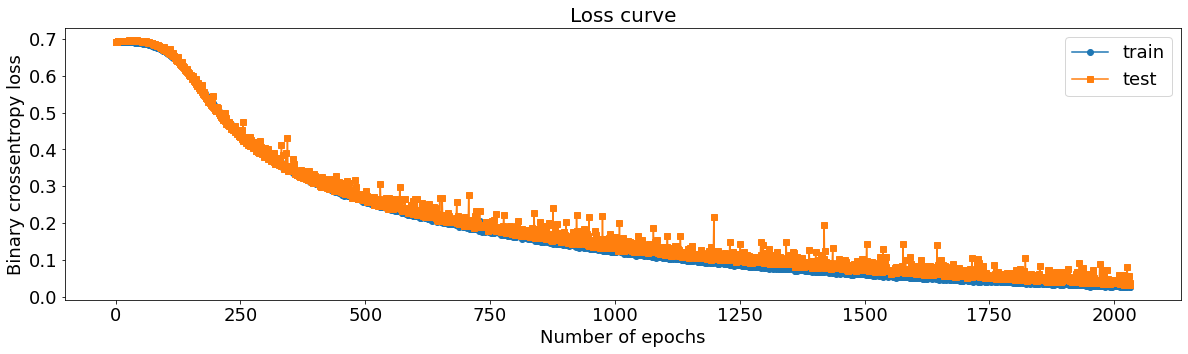

In [32]:
#---Summarize history for loss
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-s')
plt.title('Loss curve',fontsize=20)
plt.ylabel('Binary crossentropy loss',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='upper right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()
#plt.savefig('LossCurve_2class_1dcnn.eps', format='eps')

### Accuracy

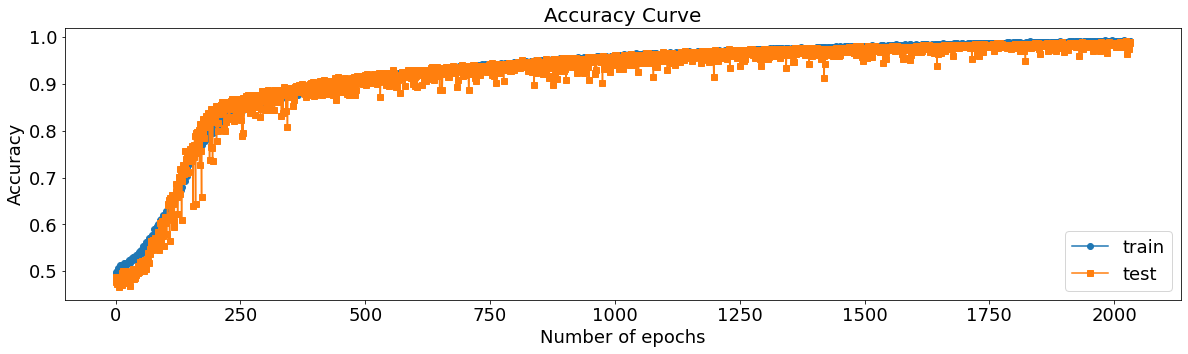

In [33]:
#---Summarize history for accuracy
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'],'-o')
plt.plot(history.history['val_acc'],'-s')
plt.title('Accuracy Curve',fontsize=20)
plt.ylabel('Accuracy',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()
#plt.savefig('AccCurve_2class_1dcnn.eps', format='eps')

### Recall

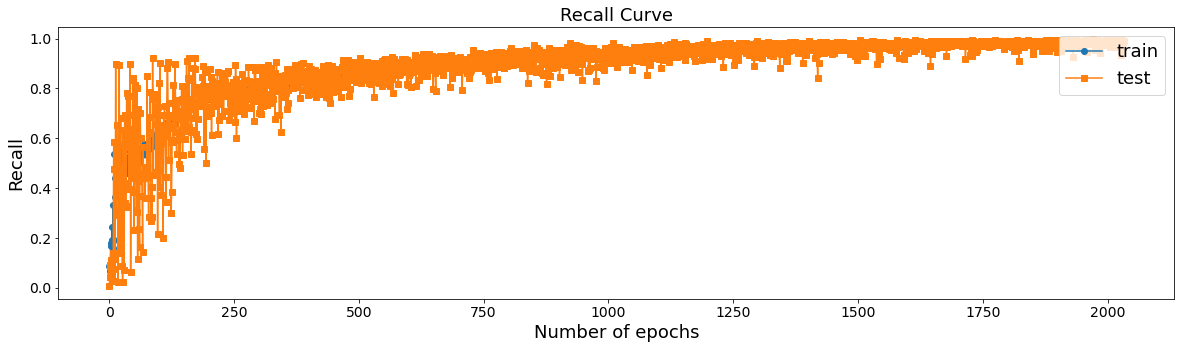

In [42]:
#---Summarize history for Recall
plt.figure(figsize=(20,5))
plt.plot(history.history['recall_m'],'-o')
plt.plot(history.history['val_recall_m'],'-s')
plt.title('Recall Curve',fontsize=18)
plt.ylabel('Recall',fontsize=18)
#plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='upper right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()
#plt.savefig('RecallCurve_2class_1dcnn.eps', format='eps')

### Precision

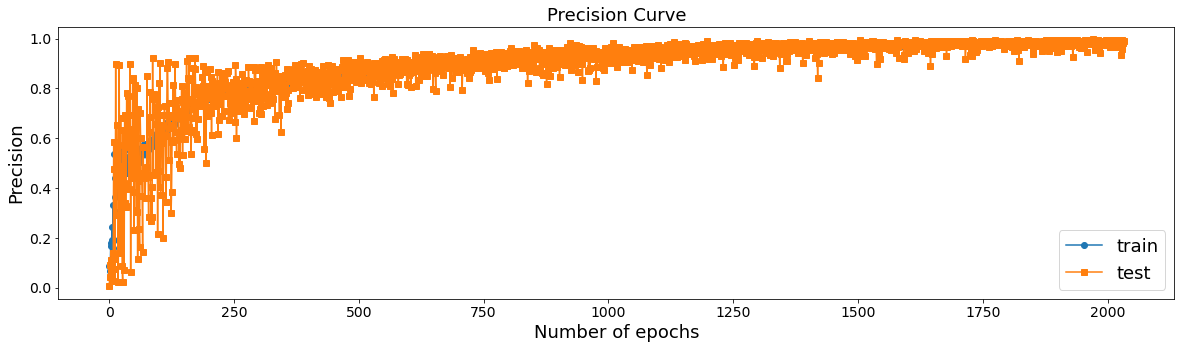

In [43]:
#---Summarize history for Precision
plt.figure(figsize=(20,5))
plt.plot(history.history['recall_m'],'-o')
plt.plot(history.history['val_recall_m'],'-s')
plt.title('Precision Curve',fontsize=18)
plt.ylabel('Precision',fontsize=18)
#plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()
#plt.savefig('PrecisionCurve_2class_1dcnn.eps', format='eps')

## Network's values

### Output of final layer

In [ ]:
# trained model weights
layer_outputs = model.layers[6].output
print(layer_outputs.shape)
print(layer_outputs)

### Weights and biases 

In [ ]:
layer_weights = model.layers[0].get_weights()[0]
print(layer_weights.shape)
print(layer_weights)

In [ ]:
layer_biases  = model.layers[0].get_weights()[1]
print(layer_biases.shape)
print(layer_biases)

## Predictions

### Predict

In [44]:
y_predicted = model.predict(X_valid, verbose = 2)
y_actual = y_valid

In [45]:
print(y_predicted)

[[1.9742695e-04]
 [9.4511372e-01]
 [3.0578154e-03]
 ...
 [9.2609393e-05]
 [9.9991024e-01]
 [9.9977952e-01]]


In [46]:
# rounding the predictions
y_pred = np.round(y_predicted)

### Confusion Matrix

In [47]:
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[884   6]
 [ 11 905]]


In [48]:
# This is a function to plot confusion matrix --> Do not disturb this
# Confusion matrix gives a representation of True positive, True Negatives, False Positives and False Negatives
from sklearn.utils.multiclass import unique_labels
import itertools
import matplotlib.pyplot as plt
from keras.utils import to_categorical

fig = plt.gcf()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i,j],
      horizontalalignment = 'center',
      color = "white" if cm[i,j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[884   6]
 [ 11 905]]


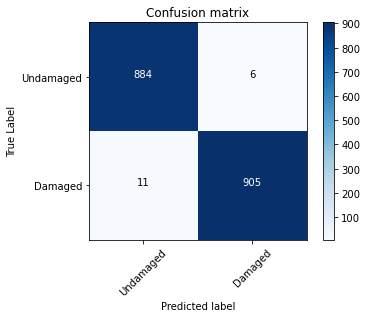

In [49]:
# Plot Non-Normalized confusion matrix
cm_labels = ['Undamaged','Damaged']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


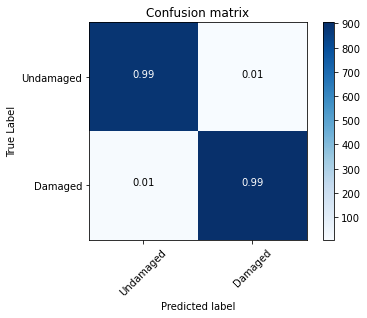

In [50]:
# Plot Normalized confusion matrix
cm_labels = ['Undamaged','Damaged']
plot_confusion_matrix(cm, classes=cm_labels, normalize = True, title='Confusion matrix')

### Classification Report

In [51]:
# Classification Report
print('Classification Report')
target_names = ['Case1_undamaged', 'Case2_damaged']
print(classification_report(y_actual, y_pred, target_names = target_names))

Classification Report
                 precision    recall  f1-score   support

Case1_undamaged       0.99      0.99      0.99       890
  Case2_damaged       0.99      0.99      0.99       916

       accuracy                           0.99      1806
      macro avg       0.99      0.99      0.99      1806
   weighted avg       0.99      0.99      0.99      1806



### AUC - ROC curve 

In [ ]:
# It is a performance measurement for classification problem at various thresholds settings. 
# ROC is a probability curve and AUC represents degree or measure of separability. 
# AUC stands for "Area under the ROC Curve." 
# AUC measures the entire two-dimensional area underneath the entire ROC curve.
# The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

In [52]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_actual, y_pred)

In [53]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)

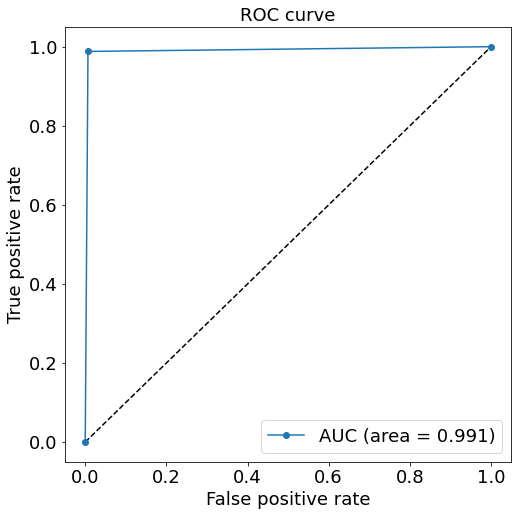

In [54]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,'-o', label='AUC (area = {:.3f})'.format(auc_value))
plt.xlabel('False positive rate',fontsize=18)
plt.ylabel('True positive rate',fontsize=18)
plt.title('ROC curve',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()